# Цель проекта:
Дана информация о постах с платформы реддит, необходимо определить, является ли контент поста для людей старше 18 лет.

In [78]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from wordcloud import STOPWORDS, WordCloud

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("~/Загрузки/dataisbeautiful_posts.csv.zip", compression='zip')
df.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,gg0j19,[OC] A 3D visualization of covid19 evolution i...,1,oniltonmaciel,NaN,NaN,0.0,[],1588968371,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,gg0fz2,[OC] My household oil consumption and price si...,1,drfronkonstein,NaN,NaN,0.0,[],1588968103,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
2,gg0f9g,Most popular states for people leaving New Yor...,1,AKWorld135,OC: 2,NaN,0.0,[],1588968045,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
3,gg0czr,[OC] Several animated climate maps showing a y...,1,MrTeacherMan,NaN,NaN,0.0,[],1588967860,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,gg08xz,Web Scraping with Python,1,yakult2450,NaN,NaN,0.0,[],1588967523,https://www.reddit.com/r/dataisbeautiful/comme...,0,False


In [3]:
df.isna().sum()

id                            0
title                         1
score                         0
author                        0
author_flair_text        155089
removed_by               169417
total_awards_received    140006
awarders                 150681
created_utc                   0
full_link                     0
num_comments                  0
over_18                       0
dtype: int64

In [4]:
df.drop(['id', 'author_flair_text', 'removed_by', 'total_awards_received',
         'awarders', 'created_utc', 'full_link'], axis=1, inplace=True)

In [5]:
df.head()

,title,score,author,num_comments,over_18
0,[OC] A 3D visualization of covid19 evolution i...,1,oniltonmaciel,0,False
1,[OC] My household oil consumption and price si...,1,drfronkonstein,0,False
2,Most popular states for people leaving New Yor...,1,AKWorld135,0,False
3,[OC] Several animated climate maps showing a y...,1,MrTeacherMan,0,False
4,Web Scraping with Python,1,yakult2450,0,False


In [6]:
df.title.fillna(' ', inplace=True)

In [7]:
df['text'] = df.title + ' ' + df.author
df.drop(['title', 'author'], axis=1, inplace=True)
df.head()

,score,num_comments,over_18,text
0,1,0,False,[OC] A 3D visualization of covid19 evolution i...
1,1,0,False,[OC] My household oil consumption and price si...
2,1,0,False,Most popular states for people leaving New Yor...
3,1,0,False,[OC] Several animated climate maps showing a y...
4,1,0,False,Web Scraping with Python yakult2450


In [8]:
df.over_18.replace([True, False], [1,0], inplace=True)

In [9]:
df.over_18.value_counts()

0    177394
1       918
Name: over_18, dtype: int64

In [10]:
x = df[:100_000]
train_false = x[x.over_18 == 0].text
train_true = x[x.over_18 == 1].text
train_text = df.text.values[:100_000]
test_text = df.text.values[100_000:]
train_category = df.over_18[:100_000]
test_category = df.over_18[100_000:]

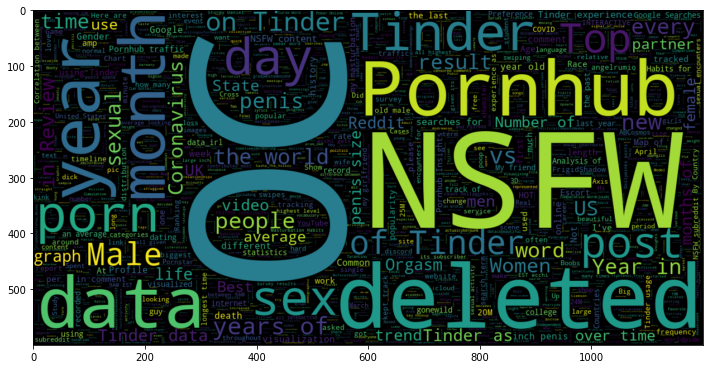

In [11]:
plt.figure(figsize=(12,12))

wc = WordCloud(min_font_size=3, max_words=3000,width=1200, height=600, stopwords = STOPWORDS).generate(str(' '.join(train_true)))
plt.imshow(wc, interpolation='bilinear')

In [12]:
text_true = wc.process_text(str(' '.join(train_true)))
text_true1 = sorted(text_true.items(), reverse=True, key=lambda x: x[1])

text_true1[:5]

[('OC', 308), ('NSFW', 72), ('deleted', 61), ('Pornhub', 45), ('data', 39)]

In [13]:
len(text_true1)

2064

In [14]:
ans_true = []

for i in text_true1:
    ans_true.append(i[0])
ans_true[:5]

['OC', 'NSFW', 'deleted', 'Pornhub', 'data']

In [15]:
predictions = []

for i in test_text:
    x = i.split()
    for j in x:
        if j in ans_true:
            predictions.append(1)
            break
        else:
            predictions.append(0)
            break
len(predictions)

78312

In [16]:
len(test_category)

78312

In [17]:
count = 0

for i in range(len(predictions)):
    test_category = list(test_category)
    if predictions[i] == int(test_category[i]):
        count += 1
count

70397

In [18]:
accuracy = count/len(predictions) * 100

print("Accuracy с использованием WordCloud: {:.2f} %".format(accuracy))

Accuracy с использованием WordCloud: 89.89 %


In [48]:
stop = stopwords.words('english')
punctuation = list(string.punctuation)

stop.extend(punctuation)



In [49]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [50]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(), get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text

In [55]:
df.text = df.text.apply(lemmatize_words)

In [56]:
def join_text(text):
    string = ' '
    for i in text:
        string += i.strip() + ' '
    return string

In [57]:
df.text = df.text.apply(join_text)

In [58]:
train_message = df.text[:150_000]
test_message = df.text[150_000:]
train_category = df.over_18[:150_000]
test_category = df.over_18[150_000:]

In [60]:
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,2))

cv_train_reviews = cv.fit_transform(train_message)

cv_test_reviews = cv.transform(test_message)

print(f"Мешок слов трен.сета: {cv_train_reviews.shape}\nМешок слов тест.сета: {cv_test_reviews.shape}")

Мешок слов трен.сета: (150000, 538882)
Мешок слов тест.сета: (28312, 538882)


In [61]:
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,2))

tv_train_reviews = tv.fit_transform(train_message)

tv_test_reviews = tv.transform(test_message)

print(f"Мешок трен.сета: {tv_train_reviews.shape}\nМешок тест.сета: {tv_test_reviews.shape}")

Мешок трен.сета: (150000, 538882)
Мешок тест.сета: (28312, 538882)


In [62]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

lr_bow = lr.fit(cv_train_reviews, train_category)

lr_tfidf = lr.fit(tv_train_reviews, train_category)

In [63]:
lr_bow_predict = lr.predict(cv_test_reviews)

lr_tfidf_predict = lr.predict(tv_test_reviews)

In [64]:
lr_bow_score = accuracy_score(test_category, lr_bow_predict)
print("lr_bow_score: ", lr_bow_score)

lr_tfidf_score = accuracy_score(test_category, lr_tfidf_predict)
print("lr_tfidf_score: ", lr_tfidf_score)


lr_bow_score:  0.9961500423848545
lr_tfidf_score:  0.9961500423848545


In [65]:
lr_bow_report = classification_report(test_category, lr_bow_predict, target_names=['0','1'])
print(lr_bow_report)

lr_tfidf_report = classification_report(test_category, lr_tfidf_predict, target_names=['0','1'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28203
           1       0.00      0.00      0.00       109

    accuracy                           1.00     28312
   macro avg       0.50      0.50      0.50     28312
weighted avg       0.99      1.00      0.99     28312

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28203
           1       0.00      0.00      0.00       109

    accuracy                           1.00     28312
   macro avg       0.50      0.50      0.50     28312
weighted avg       0.99      1.00      0.99     28312



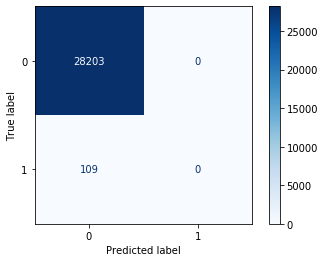

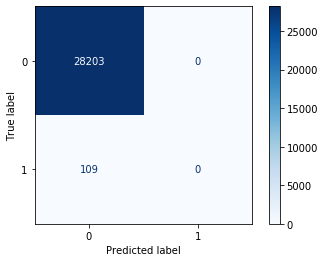

In [66]:
plot_confusion_matrix(lr_bow, cv_test_reviews, test_category,
                      display_labels=['0','1'], cmap='Blues', values_format='')

plot_confusion_matrix(lr_tfidf, tv_test_reviews, test_category,
                      display_labels=['0','1'], cmap='Blues', values_format='')

In [67]:
mnb = MultinomialNB()
mnb_bow = mnb.fit(cv_train_reviews, train_category)

mnb_tfidf = mnb.fit(tv_train_reviews, train_category)

In [68]:
mnb_bow_predict = mnb.predict(cv_test_reviews)
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

In [69]:
mnb_bow_score = accuracy_score(test_category, mnb_bow_predict)
print("mnb_bow_score: ", mnb_bow_score)

mnb_tfidf_score = accuracy_score(test_category, mnb_tfidf_predict)
print("mnb_tfidf_score: ", mnb_tfidf_score)

mnb_bow_score:  0.9961500423848545
mnb_tfidf_score:  0.9961500423848545


In [70]:
mnb_bow_report = classification_report(test_category, mnb_bow_predict, target_names = ['0','1'])
print(mnb_bow_report)
mnb_tfidf_report = classification_report(test_category, mnb_tfidf_predict, target_names = ['0','1'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28203
           1       0.00      0.00      0.00       109

    accuracy                           1.00     28312
   macro avg       0.50      0.50      0.50     28312
weighted avg       0.99      1.00      0.99     28312

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28203
           1       0.00      0.00      0.00       109

    accuracy                           1.00     28312
   macro avg       0.50      0.50      0.50     28312
weighted avg       0.99      1.00      0.99     28312



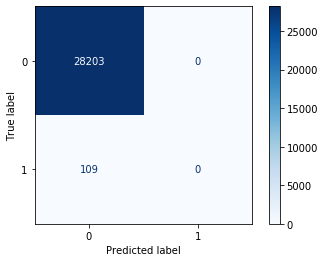

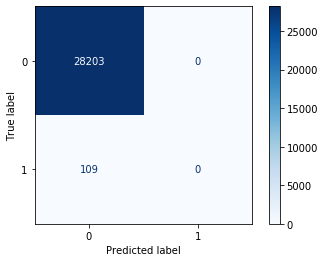

In [71]:
plot_confusion_matrix(mnb_bow, cv_test_reviews, test_category,
                      display_labels=['0','1'], cmap="Blues", values_format = '')

plot_confusion_matrix(mnb_tfidf, tv_test_reviews, test_category,
                      display_labels=['0','1'], cmap="Blues", values_format = '')

# Вывод:
Простейший фильтр на основе модели WoldCloud показал лучше результат посравнению с моделью Логистической регрессии (классификации) с применением модулей CountVectorizer и TfidfVectorizer. Из этого можно сделать заключение, что по названию поста точно определить возрастную категорию практически невозможно, необходимо дополнить данные информацией содержащую основной контент(Фото, видео либо текст).